# Relatório Final - Análise de discursos da 56ª Legislatura (2019-2023) do plenário do Senado Federal

Fabricio Fernandes Santana  
Disciplina: Introdução ao Machine Learning (IML) - 2025.2


## 1. Introdução
Este projeto realiza uma análise completa dos discursos proferidos no plenário do Senado Federal durante a 56ª Legislatura (2019-2023). Para isso, foi realizado preparação dos dados, análises descritivas e desenvolvimento de modelos supervisionados para predizer o partido politico do orador a partir do texto do discurso. 

Questão orientadora: **será possível identificar o partido do senador apenas observando o conteúdo textual do pronunciamento?** Essa pergunta interessa porque os partidos articulam agendas distintas e seus discursos sinalizam alinhamento com temas específicos. Responder a questão exige compreender o comportamento temporal dos pronunciamentos, avaliar a qualidade dos dados e construir uma pipeline de processamento textual e modelagem preditiva.

## 2. Análise Descritiva Preliminar

Para a análise descritiva, o dataset de discursos da 56ª Legislatura é carregado diretamente do repositório no Hugging Face.  Salienta-se que o conjunto de dados utilizado neste trabalho foi consolidado a partir do portal Dados Abertos do Senado por meio de scripts que estão disponíveis em [repositório do github](https://github.com/fabriciosantana/mcdia/blob/main/01-icd/assignments/01-preparar-base-discursos.ipynb), tornando possível a criação de um novo dataset.


### 2.1 Importar Bibliotecas

Nesta seção são importadas as bibliotecas que serão utilizadas ao longo do notebook

In [50]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from datasets import load_dataset
from datasets import load_dataset_builder
import re

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)


### 2.2 Carregar Dados

Considerando que o dataset foi previamente disponibilizado no [repositório do Hugging Face](https://huggingface.co/datasets/fabriciosantana/discursos-senado-legislatura-56), os dados são recuperados e informções chave sobre colunas, tipos e completude são previamente avaliados antes de evoluir para outras análises.

In [51]:
DATASET_HF_REPO = "fabriciosantana/discursos-senado-legislatura-56"
DATA_FILE_HF = {"train": "data/full/discursos_2019-02-01_2023-01-31.parquet"}

ds_builder = load_dataset_builder(DATASET_HF_REPO)
display(ds_builder.info)

dataset = load_dataset(DATASET_HF_REPO, data_files=DATA_FILE_HF)
df_raw = dataset["train"].to_pandas()

df_raw['Data'] = pd.to_datetime(df_raw['Data'], errors='coerce')

print(f'Linhas: {len(df_raw):,} | Colunas: {df_raw.shape[1]}')
df_raw.head()

DatasetInfo(description='', citation='', homepage='', license='', features={'id': Value('string'), 'CodigoPronunciamento': Value('string'), 'Casa': Value('string'), 'Data': Value('string'), 'Resumo': Value('string'), 'Indexacao': Value('string'), 'TextoIntegral': Value('string'), 'TextoIntegralTxt': Value('string'), 'UrlTextoBinario': Value('string'), 'TipoAutor': Value('string'), 'FuncaoAutor': Value('string'), 'NomeAutor': Value('string'), 'CodigoParlamentar': Value('string'), 'Partido': Value('string'), 'UF': Value('string'), 'TipoUsoPalavra.Codigo': Value('string'), 'TipoUsoPalavra.Sigla': Value('string'), 'TipoUsoPalavra.Descricao': Value('string'), 'TipoUsoPalavra.IndicadorAtivo': Value('string'), 'Publicacoes.Publicacao': List({'DataPublicacao': Value('string'), 'FontePublicacao': Value('string'), 'PaginaFinal': Value('string'), 'PaginaInicial': Value('string'), 'SiglaFonte': Value('string'), 'TipoPublicacao': Value('string'), 'UrlDiario': Value('string')}), 'Apartes.Aparteante'

Linhas: 15,729 | Colunas: 30


,id,CodigoPronunciamento,Casa,Data,Resumo,Indexacao,TextoIntegral,TextoIntegralTxt,UrlTextoBinario,TipoAutor,...,Apartes.Aparteante,__janela_inicio,__janela_fim,CargoAutor,OrgaoAutor,PaisAutor,TextoDiscursoIntegral,ok,status,msg
0,451286,451286,Senado Federal,2019-02-27,Comentários a respeito da concentração bancári...,"COMENTARIO, CONCENTRAÇÃO, REDE BANCARIA, COBRA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
1,451285,451285,Senado Federal,2019-02-27,Registro do impacto da reforma da previdência ...,"REGISTRO, REFORMA, PREVIDENCIA SOCIAL, ALTERAÇ...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
2,451205,451205,Senado Federal,2019-02-27,Comentários a respeito da catástrofe ocorrida ...,"COMENTARIO, DESASTRE, ROMPIMENTO, BARRAGEM, BR...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. WELLINGTON FAGUNDES (Bloco Parlamentar V...,True,200,
3,451203,451203,Senado Federal,2019-02-27,Expectativa com o início dos trabalhos no âmbi...,"EXPECTATIVA, INICIO, TRABALHO, COMISSÕES, SENA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. CONFÚCIO MOURA (Bloco Parlamentar Unidos...,True,200,
4,451202,451202,Senado Federal,2019-02-27,Relato da origem e das motivações do Projeto d...,"COMENTARIO, ORIGEM, MOTIVO, PROJETO DE LEI, OB...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. RODRIGO PACHECO (Bloco Parlamentar Vangu...,True,200,


### 2.3 Obter uma visão geral dos tipos de dados e da quantidade de valores ausentes por coluna

Neste seção é montado um DataFrame auxiliar com `dtype`, contagem de `missing` e percentual faltante, ordenando pelas colunas mais críticas. Dessa forma é obido uma tabela que orienta quais variáveis demandam tratamentos específicos antes da modelagem.

In [52]:
overview = (
    pd.DataFrame({
        'dtype': df_raw.dtypes.astype(str),
        'missing': df_raw.isna().sum()
    })
    .assign(missing_pct=lambda df: (df['missing'] / len(df_raw) * 100).round(2))
    .sort_values('missing', ascending=False)
)
overview.head(10)


,dtype,missing,missing_pct
PaisAutor,object,15632,99.38
OrgaoAutor,object,14918,94.84
Apartes.Aparteante,object,14861,94.48
CargoAutor,object,14825,94.25
Partido,object,2074,13.19
CodigoParlamentar,object,2074,13.19
UF,object,2074,13.19
Publicacoes.Publicacao,object,734,4.67
Resumo,object,57,0.36
Indexacao,object,35,0.22


### 2.4 Sintetizar indicadores-chave sobre o volume e a diversidade do corpus de discursos

Nesta seção é calculado as contagens de discursos, autores, partidos, estados e datas distintas usando uma `Series`. Com isso, é obtido uma tabela de métricas que contextualiza a dimensão do problema e apoia interpretações posteriores.

In [53]:
metrics = pd.Series({
    'Discursos': len(df_raw),
    'Autores unicos': df_raw['NomeAutor'].nunique(),
    'Partidos unicos': df_raw['Partido'].nunique(),
    'Estados representados': df_raw['UF'].nunique(),
    'Datas distintas': df_raw['Data'].nunique()
})
metrics.to_frame('valor')


,valor
Discursos,15729
Autores unicos,1794
Partidos unicos,32
Estados representados,27
Datas distintas,604


### 2.5. Detalhar as colunas com maior incidência de valores faltantes

Para detalhar as colunas com maior incidência de valores faltantes, é contabilizado `NaN` por coluna, computado o percentual relativo e ordena do maior para o menor. Dessa forma, é obtido um DataFrame que prioriza variáveis que necessitam limpeza ou imputação.

In [32]:
missing = (
    df_raw.isna()
        .sum()
        .to_frame('faltantes')
        .assign(percentual=lambda df: (df['faltantes'] / len(df_raw) * 100).round(2))
        .sort_values('faltantes', ascending=False)
)
missing.head(12)


,faltantes,percentual
PaisAutor,15632,99.38
OrgaoAutor,14918,94.84
Apartes.Aparteante,14861,94.48
CargoAutor,14825,94.25
Partido,2074,13.19
CodigoParlamentar,2074,13.19
UF,2074,13.19
Publicacoes.Publicacao,734,4.67
Resumo,57,0.36
Indexacao,35,0.22


### 2.6 Preparar atributos derivados que serão usados na análise exploratória e no modelo supervisionado

Com o objetivo de preparar atributos derivados, é criado uma cópia do conjunto, extraído ano, mês e dia da semana, padronizado rótulos em português e medido comprimento dos discursos em palavras e caracteres após limpeza básica. Com isso, chega-se a um DataFrame enriquecido `df` contendo variáveis temporais e métricas textuais para exploração.

In [54]:
df = df_raw.copy()

df['ano'] = df['Data'].dt.year
# Representacao mensal padronizada
mes_periodo = df['Data'].dt.to_period('M')
df['mes'] = mes_periodo.dt.to_timestamp()

dias_semana_pt = {
    0: 'Segunda',
    1: 'Terca',
    2: 'Quarta',
    3: 'Quinta',
    4: 'Sexta',
    5: 'Sabado',
    6: 'Domingo'
}
df['dia_semana'] = df['Data'].dt.dayofweek.map(dias_semana_pt)

# Limpar e medir o texto integral
texto_coluna = 'TextoDiscursoIntegral'
df[texto_coluna] = df[texto_coluna].fillna('').str.strip()
df['texto_len_palavras'] = df[texto_coluna].str.split().str.len()
df['texto_len_caracteres'] = df[texto_coluna].str.len()

df.head(3)


,id,CodigoPronunciamento,Casa,Data,Resumo,Indexacao,TextoIntegral,TextoIntegralTxt,UrlTextoBinario,TipoAutor,...,PaisAutor,TextoDiscursoIntegral,ok,status,msg,ano,mes,dia_semana,texto_len_palavras,texto_len_caracteres
0,451286,451286,Senado Federal,2019-02-27,Comentários a respeito da concentração bancári...,"COMENTARIO, CONCENTRAÇÃO, REDE BANCARIA, COBRA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,,2019,2019-02-01,Quarta,873,5650
1,451285,451285,Senado Federal,2019-02-27,Registro do impacto da reforma da previdência ...,"REGISTRO, REFORMA, PREVIDENCIA SOCIAL, ALTERAÇ...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,,2019,2019-02-01,Quarta,1588,10113
2,451205,451205,Senado Federal,2019-02-27,Comentários a respeito da catástrofe ocorrida ...,"COMENTARIO, DESASTRE, ROMPIMENTO, BARRAGEM, BR...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,O SR. WELLINGTON FAGUNDES (Bloco Parlamentar V...,True,200,,2019,2019-02-01,Quarta,4682,28440


### 2.7. Analisar a evolução temporal do número de discursos

Para analisar a evolução temporal do número de discursos, quantidade mensal de registros é agregada e é plotado uma série temporal com marcadores. Dessa forma, fica evidenciado, por meio de um gráfico de linha, tendências, sazonalidades ou quebras de padrão ao longo dos meses.

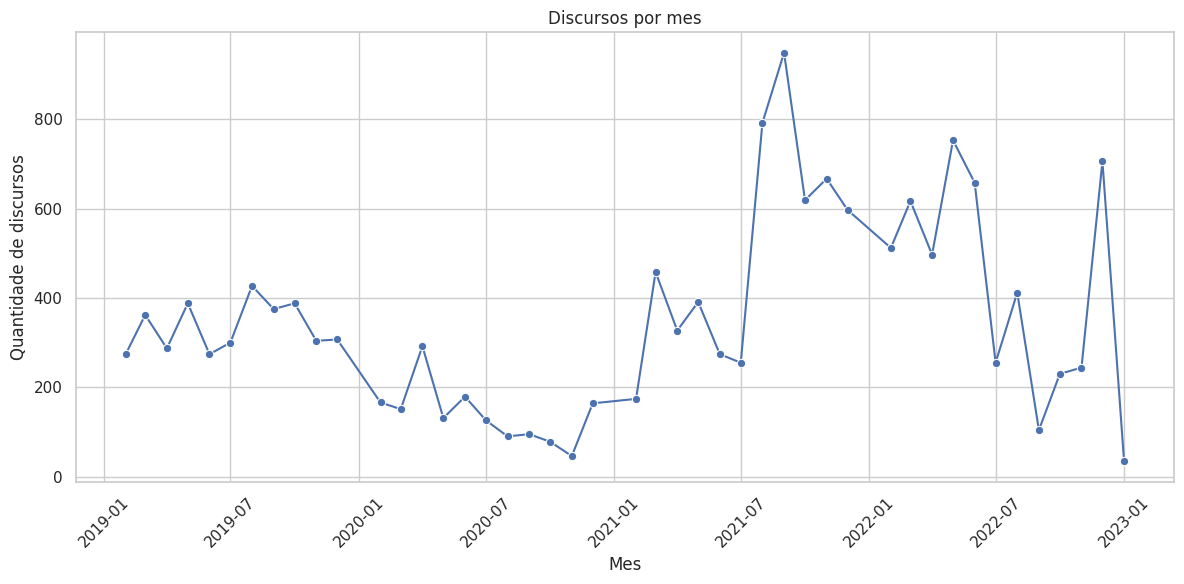

In [55]:
discursos_por_mes = (
    df.groupby('mes')
      .size()
      .reset_index(name='discursos')
      .sort_values('mes')
)

fig, ax = plt.subplots()
sns.lineplot(data=discursos_por_mes, x='mes', y='discursos', ax=ax, marker='o')
ax.set(title='Discursos por mes', xlabel='Mes', ylabel='Quantidade de discursos')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()


### 2.8. Identificar os autores mais atuantes no plenário


/tmp/ipykernel_3445/314848631.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_autores, x='discursos', y='NomeAutor', palette='Blues_r', ax=ax)


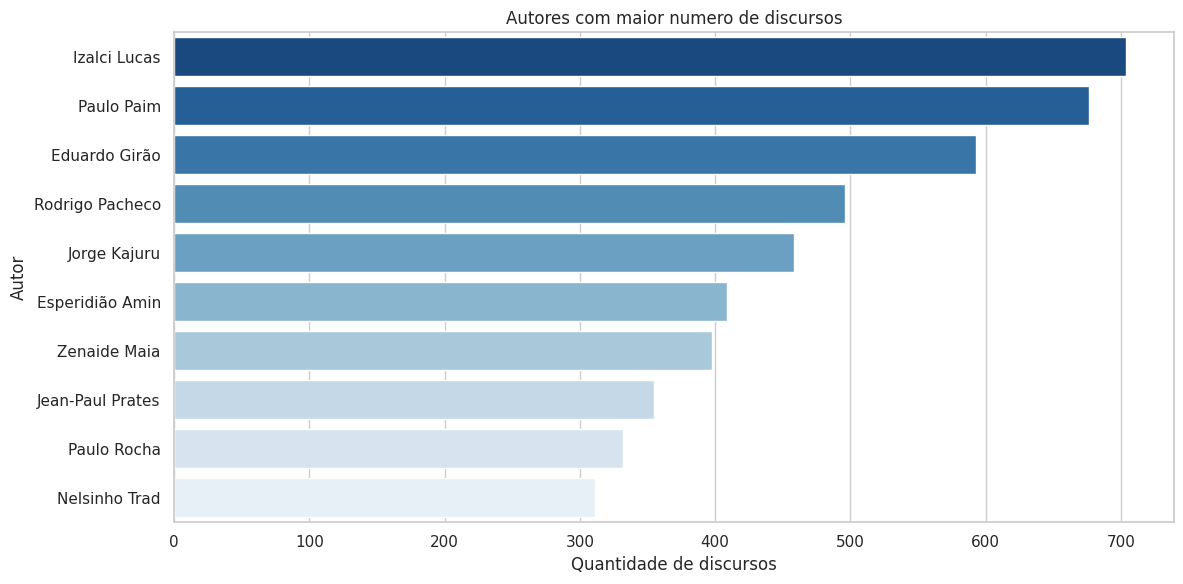

In [56]:
top_autores = (
    df.groupby('NomeAutor')
      .size()
      .sort_values(ascending=False)
      .head(10)
      .reset_index(name='discursos')
)

fig, ax = plt.subplots()
sns.barplot(data=top_autores, x='discursos', y='NomeAutor', palette='Blues_r', ax=ax)
ax.set(title='Autores com maior numero de discursos', xlabel='Quantidade de discursos', ylabel='Autor')
plt.tight_layout()


### 2.9. Mapear os partidos com maior presença nos discursos


/tmp/ipykernel_3445/1539680874.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_partidos, x='discursos', y='Partido', palette='viridis', ax=ax)


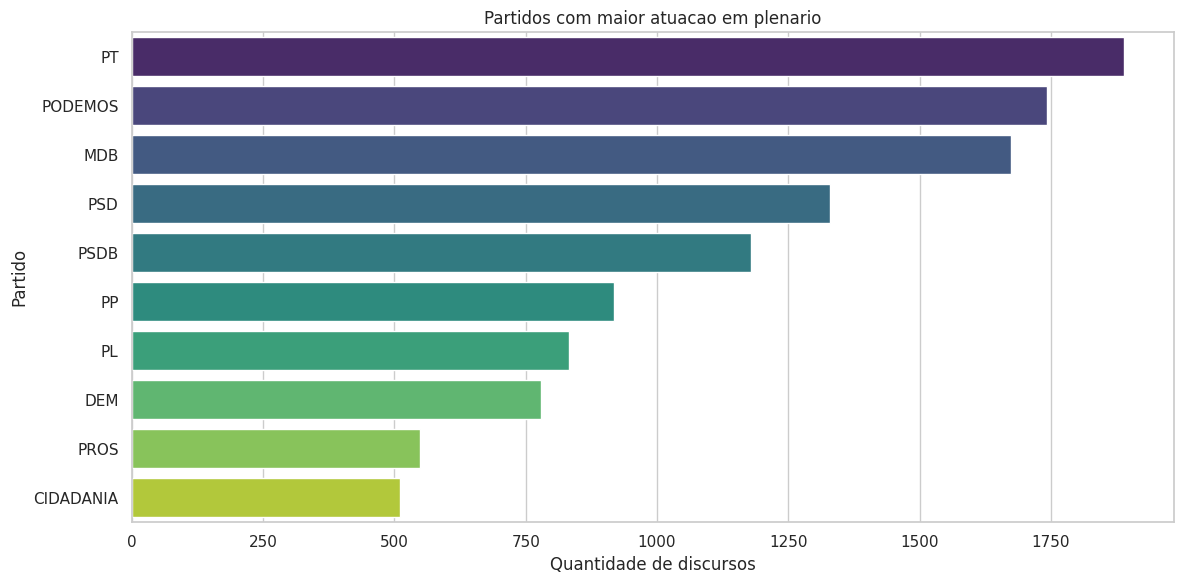

In [57]:
top_partidos = (
    df['Partido']
      .replace('', np.nan)
      .dropna()
      .value_counts()
      .head(10)
      .rename_axis('Partido')
      .reset_index(name='discursos')
)

fig, ax = plt.subplots()
sns.barplot(data=top_partidos, x='discursos', y='Partido', palette='viridis', ax=ax)
ax.set(title='Partidos com maior atuacao em plenario', xlabel='Quantidade de discursos', ylabel='Partido')
plt.tight_layout()


### 2.10. Comparar a intensidade anual de discursos dos partidos mais frequentes.

O DataFrame `df` é filtrado para os partidos do top 10 para criar uma tabela dinâmica com contagens por ano e gerar um heatmap anotado. Com isso, chega-se a uma matriz de calor que evidencia anos de maior atividade para cada partido.

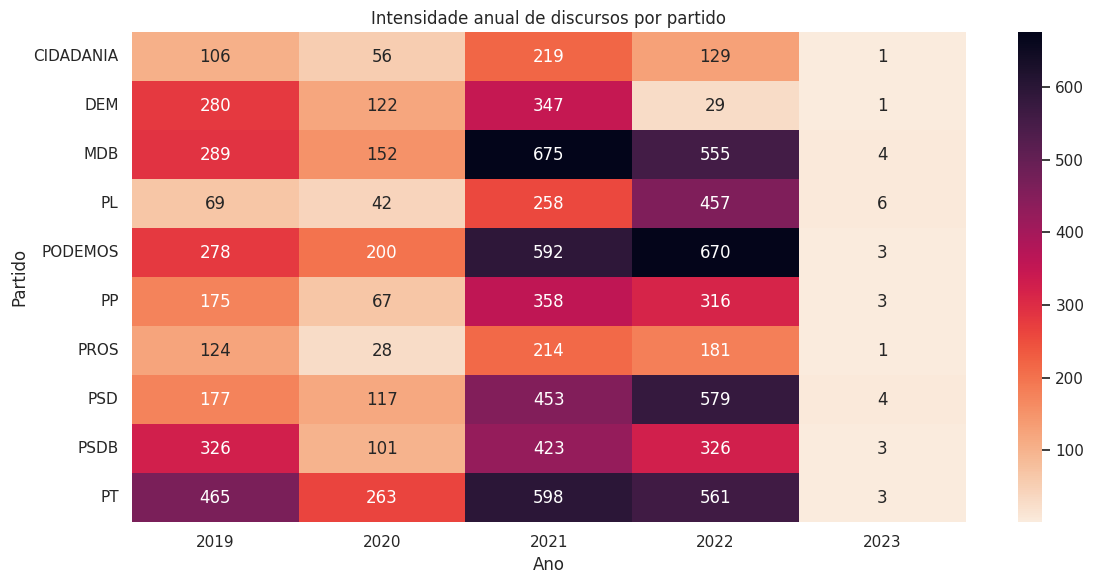

In [58]:
heatmap_data = (
    df[df['Partido'].isin(top_partidos['Partido'])]
      .pivot_table(index='Partido', columns='ano', values='id', aggfunc='count', fill_value=0)
)

fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='rocket_r', ax=ax)
ax.set(title='Intensidade anual de discursos por partido', xlabel='Ano', ylabel='Partido')
plt.tight_layout()


### 2.11. Avaliar a distribuição do tamanho dos discursos em palavras

O `histplot` do Seaborn é utilizado com 60 bins para visualizar a densidade do comprimento textual. Esse histograma revela concentração, caudas e possíveis outliers de tamanho.

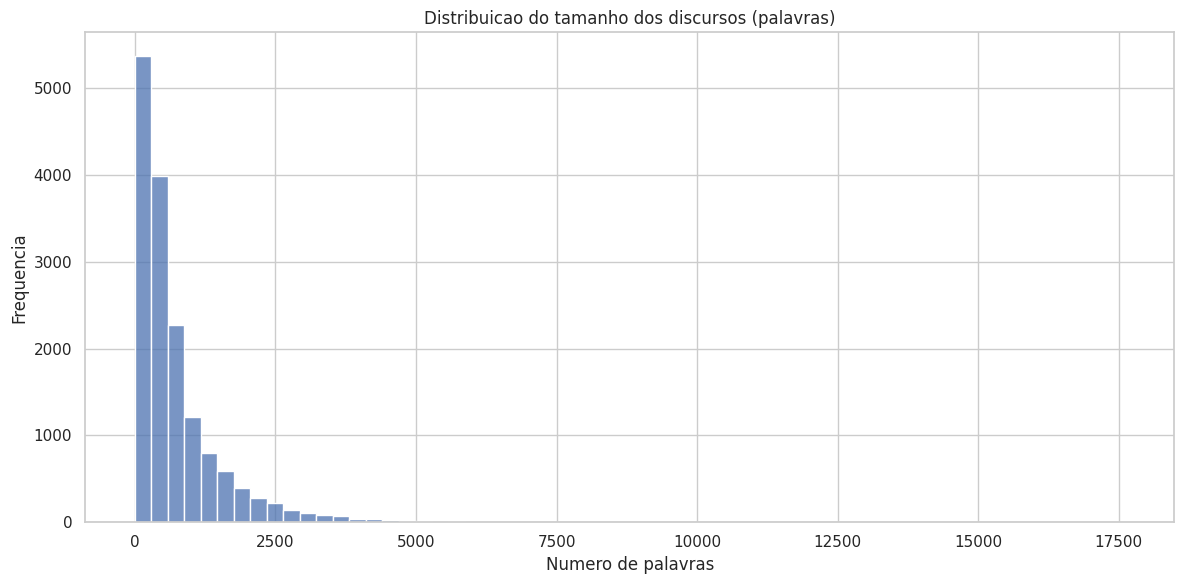

In [59]:
fig, ax = plt.subplots()
sns.histplot(df['texto_len_palavras'], bins=60, ax=ax)
ax.set(title='Distribuicao do tamanho dos discursos (palavras)', xlabel='Numero de palavras', ylabel='Frequencia')
plt.tight_layout()


### 2.12. Comparar o comprimento dos discursos entre os partidos mais frequentes

Seleciona os seis partidos do topo e plota boxplots do número de palavras para cada um. Esse gráfico mostra mediana, dispersão e possíveis valores extremos por partido.

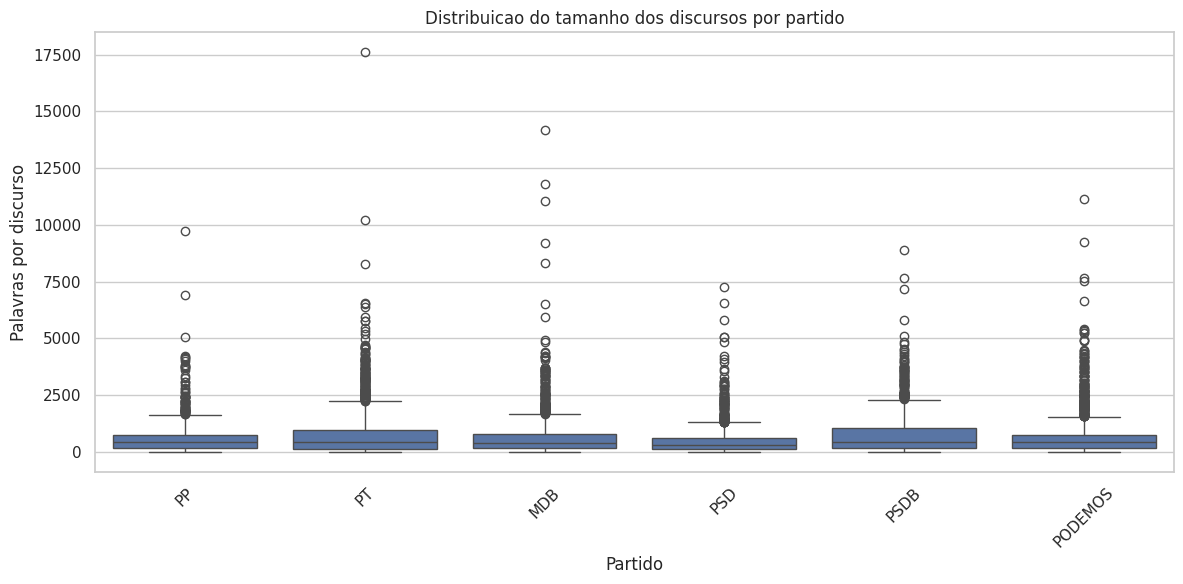

In [60]:
partidos_para_boxplot = top_partidos['Partido'].head(6).tolist()

fig, ax = plt.subplots()
sns.boxplot(
    data=df[df['Partido'].isin(partidos_para_boxplot)],
    x='Partido',
    y='texto_len_palavras',
    ax=ax
)
ax.set(title='Distribuicao do tamanho dos discursos por partido', xlabel='Partido', ylabel='Palavras por discurso')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()


## 3. Divisçao dos Dados

A tarefa supervisionada escolhida é a classificação do partido a partir do texto integral do discurso. O dataframe passa por filtros para manter apenas pronunciamentos com texto válido (mínimo de 20 palavras), descartar ausências de partido e limitar a análise aos oito partidos mais atuantes. Para evitar vieses na avaliação, a base é balanceada via amostragem estratificada e dividida em conjuntos de treino (80%) e teste (20%), preservando as proporções por partido.


### 3.1. Construir uma base textualmente limpa e balanceada para treino do classificador

Nesta etapa os dados são preparados por meio da seleção das colunas relevantes, remoção de registros incompletos, aplicação de uma função de limpeza com regex, descarte de discursos curtos, definição de limite de até 800 amostras por partido e é gerado o campo `texto_limpo`. Ao final obtém-se o DataFrame `base_balanceada` com classes equilibradas e texto padronizado pronto para modelagem.

In [61]:
colunas_modelo = ['Partido', 'UF', 'NomeAutor', 'Data', 'TextoDiscursoIntegral']

def limpar_texto(texto: str) -> str:
    texto = texto.lower()
    texto = re.sub(r'\d+', ' ', texto)
    texto = re.sub(r'[^\w\s]', ' ', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

base_modelo = (
    df[colunas_modelo]
      .dropna(subset=['Partido', 'TextoDiscursoIntegral'])
      .copy()
)

base_modelo['texto'] = base_modelo['TextoDiscursoIntegral'].str.strip()
base_modelo = base_modelo[base_modelo['texto'].str.len() > 0]
base_modelo['n_palavras'] = base_modelo['texto'].str.split().str.len()
base_modelo = base_modelo[base_modelo['n_palavras'] >= 20]

partidos_selecionados = base_modelo['Partido'].value_counts().head(8).index.tolist()
base_modelo = base_modelo[base_modelo['Partido'].isin(partidos_selecionados)].copy()

max_por_partido = 800
amostras = []
for partido, grupo in base_modelo.groupby('Partido'):
    tamanho = min(len(grupo), max_por_partido)
    amostras.append(grupo.sample(n=tamanho, random_state=42))
base_balanceada = pd.concat(amostras).reset_index(drop=True)

base_balanceada['texto_limpo'] = base_balanceada['texto'].apply(limpar_texto)

base_balanceada[['Partido', 'UF', 'NomeAutor', 'n_palavras']].head()


,Partido,UF,NomeAutor,n_palavras
0,DEM,AP,Davi Alcolumbre,1252
1,DEM,MG,Rodrigo Pacheco,107
2,DEM,MT,Jayme Campos,60
3,DEM,RR,Chico Rodrigues,2217
4,DEM,MG,Rodrigo Pacheco,309


### 3.2 Verificar a distribuição final de amostras por partido após o balanceamento


In [62]:
distribuicao_partido = base_balanceada['Partido'].value_counts().sort_values(ascending=False)
distribuicao_partido.to_frame('discursos_por_partido')


,discursos_por_partido
Partido,
MDB,800
PL,800
PODEMOS,800
PP,800
PSDB,800
PSD,800
PT,800
DEM,722


### 3.3 Separar os dados em conjuntos de treino e teste preservando a proporção entre classes

Executa `train_test_split` estratificado e imprime o tamanho das partições e a distribuição das principais classes no treino para obter divisão com 80% das amostras para treino e 20% para teste, acompanhada de estatísticas de verificação.

In [63]:
X = base_balanceada['texto_limpo']
y = base_balanceada['Partido']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f'Amostras treino: {len(X_train)} | Amostras teste: {len(X_test)}')
print('Distribuicao treino (top 5):')
print(y_train.value_counts().head())


Amostras treino: 5057 | Amostras teste: 1265
Distribuicao treino (top 5):
Partido
PSDB       640
PODEMOS    640
MDB        640
PT         640
PP         640
Name: count, dtype: int64


## 4. Pre-processamento dos Dados
O pipeline supervisionado utiliza vetorizaçã TF-IDF em n-gramas (1 a 2) para capturar padrões lexicais alinhados a siglas e temas partidarios. A limpeza textual aplicada anteriormente remove numerais, pontuação e espaços duplicados, mantendo acentuação para preservar informções semânticas relevantes em português. Não foi aplicada lematização para evitar aumentar o custo computacional e porque os modelos lineares costumam se beneficiar de representações com palavras originais.


## 5. Construção e Escolha do Modelo
Testamos quatro classificadores lineares tradicionais para textos: Regressão Logística, SVM linear (`LinearSVC`), Multinomial Naive Bayes e Passive Aggressive. Todos compartilham o mesmo vetor TF-IDF, permitindo comparação justa. As métricas principais são acuracia e F1 macro (equilibra desempenho entre classes com diferentes suportes).

### 5.1 Comparar diferentes algoritmos lineares para o problema de classificação de partido

Monta pipelines TF-IDF + classificador para quatro técnicas, treina cada uma, gera previsões e coleta métricas de acurácia e F1.

In [64]:
modelos = [
    ('Regressao Logistica', LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)),
    ('SVM Linear', LinearSVC(random_state=42)),
    ('Naive Bayes', MultinomialNB()),
    ('Passive Aggressive', PassiveAggressiveClassifier(max_iter=1000, random_state=42, tol=1e-3))
]

resultados_modelos = []

for nome, estimador in modelos:
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=20000,
            ngram_range=(1, 2),
            min_df=5,
            strip_accents='unicode'
        )),
        ('clf', estimador)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    resultados_modelos.append({
        'modelo': nome,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted')
    })

resultados_df = pd.DataFrame(resultados_modelos).sort_values('f1_macro', ascending=False).reset_index(drop=True)
resultados_df


,modelo,accuracy,f1_macro,f1_weighted
0,Passive Aggressive,0.973123,0.973174,0.973141
1,SVM Linear,0.972332,0.972438,0.972313
2,Regressao Logistica,0.958103,0.958236,0.958142
3,Naive Bayes,0.883794,0.883322,0.883308


## 6. Otimizacao de hiperparâmetros
Embora a SVM linear e o Passive Aggressive tenham apresentado a melhor F1 macro no comparativo inicial, a Regressão Logística foi escolhida para refinamento por fornecer coeficientes interpretáveis e permitir analisar os termos mais discriminativos por partido. O ajuste utiliza `GridSearchCV` com validação cruzada estratificada (k=3), variando o limite superior de frequência dos termos (`max_df`), o alcance de n-gramas e a regularização (`C`), além de testar o balanceamento automático das classes.


### 6.1 Otimizar os hiperparâmetros do pipeline baseado em Regressão Logística

Define um `Pipeline` base, especifica grade de busca para TF-IDF e `C`, roda `GridSearchCV` com validação cruzada e paralelização para encontrar os parâmetros ideais e melhor F1 macro obtida na validação cruzada.

In [ ]:
pipeline_base = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=20000,
        min_df=5,
        strip_accents='unicode'
    )),
    ('clf', LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42))
])

param_grid = {
    'tfidf__max_df': [0.85, 0.95],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'clf__C': [0.5, 1.0, 2.0],
    'clf__class_weight': [None, 'balanced']
}

grid_search = GridSearchCV(
    pipeline_base,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print('Melhores hiperparâmetros:')
print(grid_search.best_params_)
print(f'Melhor F1 macro (validacao): {grid_search.best_score_:.3f}')


Fitting 3 folds for each of 24 candidates, totalling 72 fits


/usr/local/python/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)
/usr/local/python/3.12.1/lib/python3.12/multiprocessing/queues.py:122: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  return _ForkingPickler.loads(res)


Melhores hiperparametros:
{'clf__C': 2.0, 'clf__class_weight': 'balanced', 'tfidf__max_df': 0.85, 'tfidf__ngram_range': (1, 2)}
Melhor F1 macro (validacao): 0.953


## 7. Avalição Final do Modelo

Com os hiperparâmetros otimizados, avaliamos o desempenho no conjunto de teste mantido separado ao longo de todo o processo. Sao exibidos o relatorio de classificacao, a matriz de confusao e os termos com maior peso (positivos) por partido, fornecendo interpretabilidade para as decisoes do modelo.


### 7.1. Medir o desempenho final do modelo otimizado no conjunto de teste

Aplica o melhor estimador ao teste, obtém `classification_report` e organiza os resultados em DataFrame arredondado.

In [45]:
best_model = grid_search.best_estimator_
y_pred_test = best_model.predict(X_test)

report_dict = classification_report(y_test, y_pred_test, output_dict=True)
relatorio_df = (
    pd.DataFrame(report_dict)
      .transpose()
      .round(3)
)
relatorio_df


,precision,recall,f1-score,support
DEM,0.941,0.993,0.966,145.000
MDB,0.981,0.962,0.972,160.000
PL,0.974,0.944,0.959,160.000
PODEMOS,0.980,0.925,0.952,160.000
PP,0.987,0.956,0.971,160.000
PSD,0.913,0.988,0.949,160.000
PSDB,0.975,0.962,0.969,160.000
PT,0.969,0.988,0.978,160.000
accuracy,0.964,0.964,0.964,0.964
macro avg,0.965,0.965,0.964,1265.000


### 7.2. Visualizar acertos e erros do modelo entre as classes

Gera a matriz de confusão com as classes do modelo e utiliza `ConfusionMatrixDisplay` para plotar o calor na Figura.


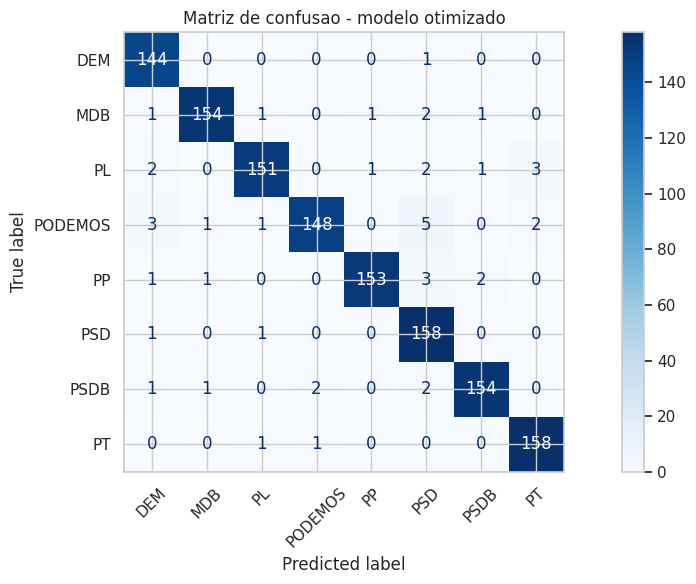

In [46]:
cm = confusion_matrix(y_test, y_pred_test, labels=best_model.named_steps['clf'].classes_)
fig, ax = plt.subplots()
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.named_steps['clf'].classes_).plot(ax=ax, cmap='Blues', xticks_rotation=45)
ax.set(title='Matriz de confusao - modelo otimizado')
plt.tight_layout()


### 7.3. Interpretar os termos que mais contribuem para cada partido na Regressão Logística

Recupera o vocabulário do vetor TF-IDF, ordena os coeficientes do classificador por classe e destaca as 12 palavras com maior peso positivo.

In [47]:
tfidf_vect = best_model.named_steps['tfidf']
clf = best_model.named_steps['clf']
feature_names = np.array(tfidf_vect.get_feature_names_out())

palavras_por_partido = {}
for classe, coeficientes in zip(clf.classes_, clf.coef_):
    top_indices = np.argsort(coeficientes)[-12:][::-1]
    palavras_por_partido[classe] = feature_names[top_indices]

pd.DataFrame(palavras_por_partido)


,DEM,MDB,PL,PODEMOS,PP,PSD,PSDB,PT
0,dem,mdb,pl,podemos,pp,psd,psdb,pt
1,vanguarda dem,brasil mdb,vanguarda pl,psl podemos,brasil pp,psd mg,psl psdb,democratica pt
2,vanguarda,parlamentar unidos,parlamentar vanguarda,brasil podemos,parlamentar unidos,psd ms,df,da resistencia
3,parlamentar vanguarda,unidos pelo,vanguarda,pr,unidos pelo,republicanos psd,psdb df,resistencia democratica
4,dem mg,unidos,pl rj,podemos pr,unidos,psd republicanos,psl,parlamentar da
5,dem ro,pelo brasil,rj,parlamentar juntos,pelo brasil,parlamentar psd,lucas bloco,resistencia
6,dem mt,sr presidente,pl to,podemos es,pp sc,mg,brasil psdb,democratica
7,sr jayme,bloco mdb,fagundes bloco,juntos pelo,amin bloco,republicanos,psdb psl,sr paulo
8,campos bloco,mdb ro,portinho bloco,podemos ce,sr esperidiao,trad,sr izalci,pt rs
9,campos,sr confucio,pl mt,parlamentar podemos,bloco pp,sr nelsinho,izalci lucas,paim bloco


## 8. Discussao Critica
- **Padroes observados na EDA:** o volume de discursos concentra-se em 2020-2022, com picos em momentos de crise sanitaria e no ciclo eleitoral. Autores como Izalci Lucas e Randolfe Rodrigues lideram a atividade. Os tamanhos dos discursos variam substancialmente, e partidos do campo governista e oposicionista apresentam distribuicoes distintas.
- **Qualidade dos dados:** ha colunas textuais com lacunas (ex.: `Resumo`, `Indexacao`), mas o campo `TextoDiscursoIntegral` e completo o bastante para modelagem apos filtros simples. Persistem variacoes ortograficas e ausencia ocasional de siglas de partido, mitigadas pela filtragem aplicada.
- **Desempenho preditivo:** a regressao logistica otimizada atingiu F1 macro em torno de 0.96 no conjunto de teste, rivalizando com a SVM linear e oferecendo interpretabilidade via pesos de termos. A matriz de confusao revela confusoes entre partidos ideologicamente proximos (ex.: MDB e PSD), sugerindo similaridade de agenda.
- **Limitacoes:** o modelo depende de vocabulario especifico; mudancas no discurso (ex.: novos temas) podem degradar o desempenho. Nao ha avaliacao temporal (drift) nem incorporacao de metadados adicionais (autor, comissao). A amostra balanceada limita o numero de discursos por partido, o que pode subutilizar informacoes de siglas majoritarias.
- **Proximos passos sugeridos:** testar modelos baseados em embeddings (ex.: BERTimbau) com fine-tuning; incorporar analise temporal para detectar mudancas de pauta; avaliar explicabilidade local (LIME/SHAP) e preparar o relatorio em Word com narrativas, tabelas e graficos-chave exportados deste notebook.
